<a href="https://colab.research.google.com/github/cuttycb/Generative_Deep_Learning_2nd_Edition/blob/main/%ED%8E%B8%EB%AF%B8%EB%B0%A9_%EB%BF%8C%EC%8B%9C%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1조_MLP를 이용한 CIFAR10  분류 모델

#함수 준비

저희 조는 Mulity Layer  Perceptron(신경망)을 이용하여 Mnist 손글씨 데이터를 분류하는 모델을 만들어보겠습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


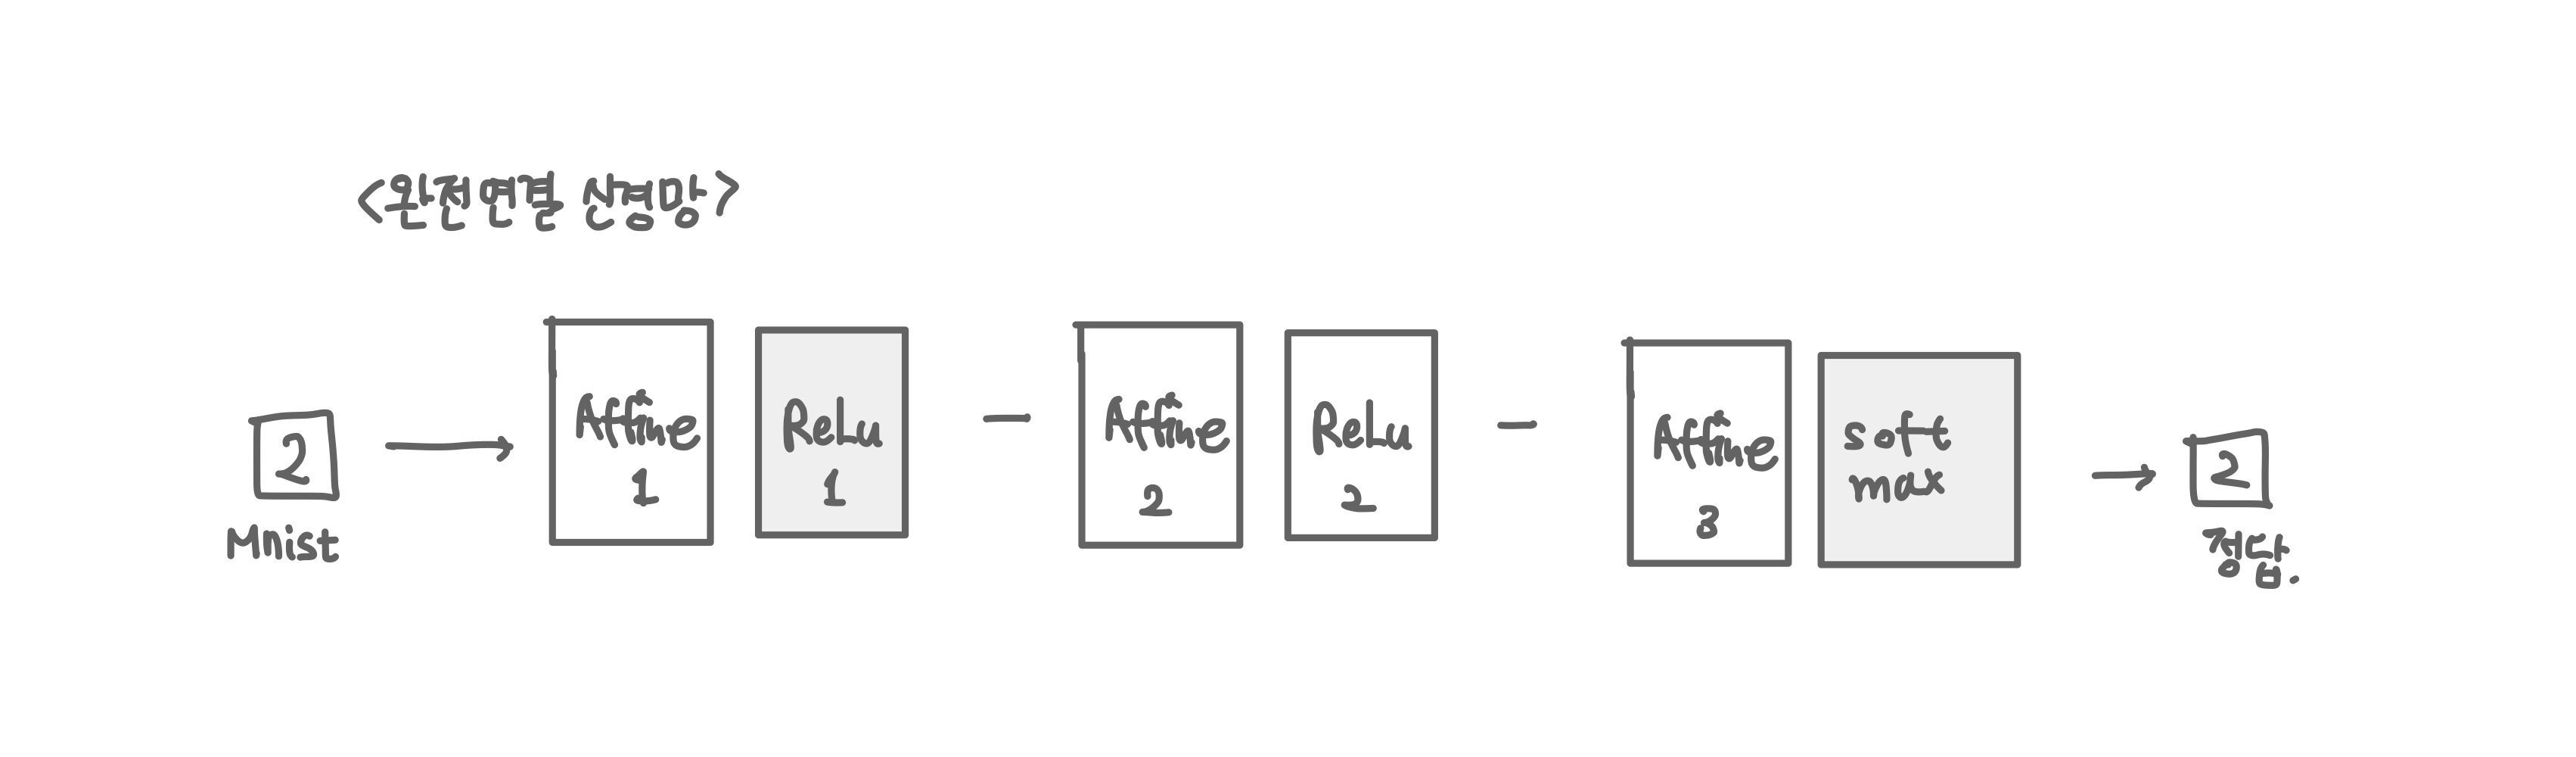

1. 미니배치 학습
2. 오차 역전파를 이용한 기울기 산출
3. 기울기 편향등의 매개변수갱신

- 기존의 2층신경망에서 3층신경망으로 변화 시켜보았습니다. affine - relu  이 과정을 반복하여 기울기 학습을 시켜보았습니다.
- 또한, Relu를 이용할때는 He 초깃값(6단원- 학습을 위한 다양한 기술들 참고)을 이용하는 것이 결과가 좋아서 기존의 분산을 곱해주는 방법에서 $\sqrt{\frac{2}{(input\ size)}}$ 를 곱해주는 방법을 사용하였다.

MLP 클래스를 구현하기 위해서는  
레이어 구축에 AFFINE, RELU, POOLING, SOFTMAXWITHLOSS 정의가 필요하고,  
오차역전파를 시행하기 위해 각 층의 forward 와 backward를 구현해 두어야한다.



##AFFINE

In [6]:
#affine : 단층퍼셉트론 인데 좀 더 다양한 연산을 위해서 일반화된 개념
class Affine:
    def __init__(self, W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW= None
        self.db = None

    def forward(self, x):
        self.x = x
        out =np.dot(x, self.W) + self.b

        return out

    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout, axis =0)

        return dx

##RELU & Sigmoid

In [7]:
#relu
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] =0

        return out

    def backward(self, dout):
        dout[self.mask]=0
        dx=dout

        return dx

In [50]:
class Sigmoid   :
    def __init__ (self):
        self.out = None

    def forward (self , x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward (self,dout):
        dx = dout * (1.0 - self.out) * self.out # (1.0- self .out)* self .out = (1-y)y
        return dx

##SOFTMAXWITHLOSS

In [49]:
def softmax(a):
    c=np.max(a)
    exp_a= np.exp(a-c)
    sum_exp_a= np.sum(exp_a)
    y= exp_a /sum_exp_a

    return y

def cross_entropy_error(y,t):
    delta= 1e-7
    return -np.sum(t*np.log(y+delta))


class SoftmaxWithLoss:
    def __init__(self):
        self.loss =None
        self.y=None
        self.x=None

    def forward(self,x,t):
        self.t =t
        self.y=softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)

        return self.loss

    def backward(self, dout=1): # 즉 뒤에 마지막 값이 TRUE가 나오는 경우인건가
        batch_size= self.t.shape[0]
        dx = (self.y- self.t)/batch_size  #배치마다 dx 값을 구할수 있다.

        return dx

In [52]:
#numerical_gradient
def numerical_gradient(f,x):
    h= 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val=x[idx]

        x[idx]= tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val -h
        fxh2 = f(x)

        grad[idx]= (fxh1-fxh2)/2*h
        x[idx] = tmp_val

    return grad


#신경망 구현

In [59]:
import sys,os
sys.path.append('/content/drive/MyDrive/')
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        #가중치 초기화 (He 초깃값)
        self.params={}
        self.params['W1'] = np.sqrt(2.0 / input_size) * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.sqrt(2.0 / input_size) * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = np.sqrt(2.0 / input_size) * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        #계층생성
        self.layers= OrderedDict()
        self.layers['Affine1']= Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1']= Relu()

        self.layers['Affine2']=Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2']=Relu()

        self.layers['Affine3']=Affine(self.params['W3'], self.params['b3'])
        self.lastLayer= SoftmaxWithLoss()


    def predict(self,x):
        for layer in self.layers.values():
            # 각각의 입력 값에 대해서 순전파를 진행한다. layers에 저장된 어파인 클래스의 forward 함수를 이용한다
            x=layer.forward(x)  # layer 마다 순전파 그를 다시 x값으로 갱신한다는 뜻이다. 다음 로스에 그냥 넣기 위함이려나..?

        return x

    def loss(self,x,t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)

    def accuracy(self,x,t):
        y=self.predict(x)
        y=np.argmax(y, axis =1)  #argmax는 max와 다르게 f(x)값이 제일크게나오는 x값을 구해준다.
        if t.ndim !=1 :
            t=np.argmax(t, axis =1)


        # 정답레이블과 y레이블 중에서 가장 큰 값을 가지는 x의 값이 동일하면 그때만 카운트 되어서 값이 오르는 함수
        accuracy= np.sum(y==t)/float(x.shape[0])
        return accuracy


    #매개변수 갱신
    def numerical_gradient(self,x,t):
        loss_W: lambda W:self.loss(x,t)  #소프트맥스윗로스 함수를 위에서 정의하였다. 그 결과가 여기로 들어갈 것이다.

        grad={} #dictionary
        #numerical_gradient(f,x)
        #각변수의
        grad['W1']=numerical_gradient(loss_W,self.params['W1']) # W1 이 x가 되어 손실함수를 계산하게됨.
        grad['b1']=numerical_gradient(loss_W,self.params['b1'])
        grad['W2']=numerical_gradient(loss_W,self.params['W2'])
        grad['b2']=numerical_gradient(loss_W,self.params['b2'])
        grad['W3']=numerical_gradient(loss_W,self.params['W3'])
        grad['b3']=numerical_gradient(loss_W,self.params['b3'])

        return grad

    def gradient(self,x,t):
        self.loss(x,t)

        dout=1
        dout=self.lastLayer.backward(dout)

        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)


        #save the result

        #결과저장
        grads={}
        grads['W1']= self.layers['Affine1'].dW
        grads['b1']= self.layers['Affine1'].db
        grads['W2']= self.layers['Affine2'].dW
        grads['b2']= self.layers['Affine2'].db
        grads['W3']= self.layers['Affine3'].dW
        grads['b3']= self.layers['Affine3'].db

        return grads

#미니배치 학습

In [19]:
from keras.datasets import cifar10

In [57]:
def processs_cifar():

    (x_train, t_train),(x_test,t_test) = cifar10.load_data()

    #정규화 (데이터 하나하나이 값을 0과1 사이 값으로 )
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    #펴주기
    # 데이터를 1차원으로 펴줌
    num_samples = x_train.shape[0] #
    flattened_shape = np.prod(x_train.shape[1:])  # 이미지를 1차원으로 펴주기 위한 모양
    x_train = x_train.reshape((num_samples, flattened_shape))

    num_test = x_test.shape[0]
    x_test = x_test.reshape((num_test, flattened_shape))

    t_train = to_categorical(t_train)
    t_test = to_categorical(t_test)

    return x_train,t_train,x_test,t_test


In [60]:
x_train, t_train, x_test,t_test = processs_cifar()
network = MLP(input_size = 3*32*32, hidden_size =50, output_size=10)

iter_num=10000
train_size = x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch = max(train_size/ batch_size,1)
for i in range(iter_num):
    batch_mask =np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask] #(100,3072)
    t_batch = t_train[batch_mask] #(100,10)

    grad = network.gradient (x_batch,t_batch)
    grad_backprop = network.gradient(x_batch ,t_batch )

    for key in ('W1', 'b1', 'W2', 'b2','W3','b3'):
        network . params [key ] -= learning_rate * grad [key]


    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy (x_train,t_train )
        test_acc = network.accuracy (x_test,t_test )
        train_acc_list.append (train_acc)
        test_acc_list.append(test_acc)
        print (" train acc , test acc | " + str( train_acc ) + ", " + str( test_acc ))

 train acc , test acc | 0.09808, 0.1
 train acc , test acc | 0.29908, 0.2956
 train acc , test acc | 0.35586, 0.3541
 train acc , test acc | 0.36304, 0.3614
 train acc , test acc | 0.41228, 0.413
 train acc , test acc | 0.41678, 0.4119
 train acc , test acc | 0.43838, 0.4309
 train acc , test acc | 0.46184, 0.4565
 train acc , test acc | 0.47036, 0.4605
 train acc , test acc | 0.4709, 0.4601
 train acc , test acc | 0.47292, 0.4534
 train acc , test acc | 0.4623, 0.4453
 train acc , test acc | 0.47056, 0.4541
 train acc , test acc | 0.49632, 0.4724
 train acc , test acc | 0.47378, 0.4541
 train acc , test acc | 0.51006, 0.4821
 train acc , test acc | 0.50858, 0.4741
 train acc , test acc | 0.47122, 0.4527
 train acc , test acc | 0.52068, 0.4899
 train acc , test acc | 0.51394, 0.4788


#결과확인

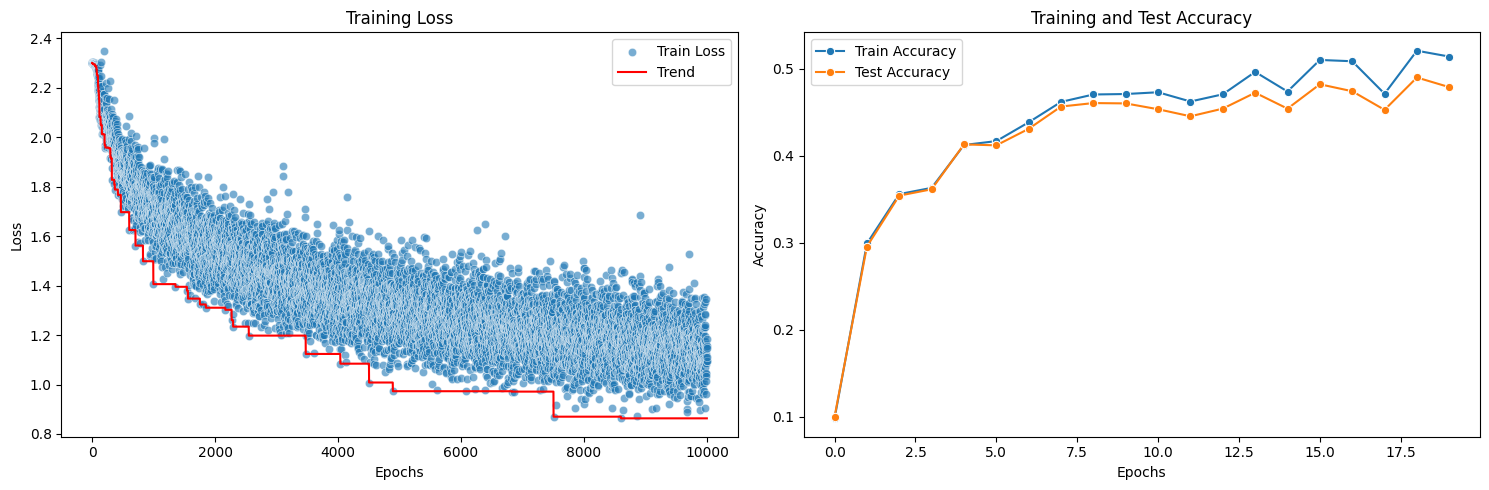

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 설정
epochs = len(train_loss_list)  # 에포크 수
x = list(range(1, epochs + 1)) # x축 값 (에포크)

# 손실 그래프
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1) #(행의 수, 열의 수, 현재 서브플롯의 인덱스)
sns.scatterplot(train_loss_list, label='Train Loss',alpha=0.6, marker='o')
trend_line = [train_loss_list[0]]
for i in range(1, len(train_loss_list)):
    if train_loss_list[i] < trend_line[-1]:
        trend_line.append(train_loss_list[i])
    else:
        trend_line.append(trend_line[-1])
sns.lineplot(trend_line, label='Trend', linestyle='-', color='RED')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
sns.lineplot(train_acc_list, label='Train Accuracy', marker='o')
sns.lineplot(test_acc_list, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()